In [1]:
!pip install tensorflow=='1.10.0'
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 58.4 MB 49.5 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 7.8 MB/s eta 0:00:01
     |████████████████████████████████| 566 kB 36.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 61.0 MB/s eta 0:00:01
ERROR: xarray 0.15.1 has requirement numpy>=1.15, but you'll have numpy 1.14.5 which is incompatible.
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: tpot 0.11.1 has requirement numpy>=1.16.3, but you'll have numpy 1.14.5 which is incompatible.
ERROR: tinycss2 1.0.2 has requirement setuptools>=39.2.0, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: tifffile 2020.2.16 has requirement numpy>=1.15.1, but you'll have numpy 1.14.5 which is incompatible.
ERROR: spacy 2.2.3 has requirement numpy>=1.15.0, but you'll have numpy 1.14.5 which is incompatible.
ERROR: ray 0.8.3 has requirement numpy>=1.16, but you'll have numpy 1.14.5 which 

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

1.10.0


In [2]:
# importing libraries required for this run 
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
%matplotlib inline
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator,  img_to_array, load_img
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from glob import glob


In [3]:
#loading data and fining out dimenstions
all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input/data/', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
75396,00018500_012.png,No Finding,12,18500,57,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_009/images/00018500_012.png
33532,00008792_000.png,Infiltration,0,8792,46,F,PA,2500,2048,0.168,0.168,NaN,../input/data/images_004/images/00008792_000.png
96884,00025543_005.png,Effusion|Infiltration,5,25543,42,F,AP,3056,2544,0.139,0.139,NaN,../input/data/images_011/images/00025543_005.png


In [4]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030801_001.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030803_000.png
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030804_000.png


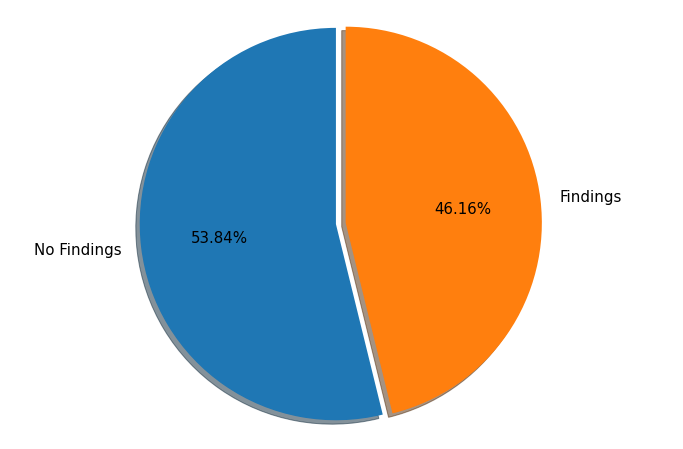

In [5]:
#ditribution of 'Finding' , 'No Finding' 
no_finding=(all_xray_df['Finding Labels'].values == 'No Finding').sum()
finding=len(all_xray_df['Finding Labels'])-no_finding
fig1, ax1 = plt.subplots(figsize = (12, 8))
plt.rcParams['font.size'] = 15
ax1.pie([no_finding, finding],explode=(0,0.05),labels=['No Findings', 'Findings'], autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

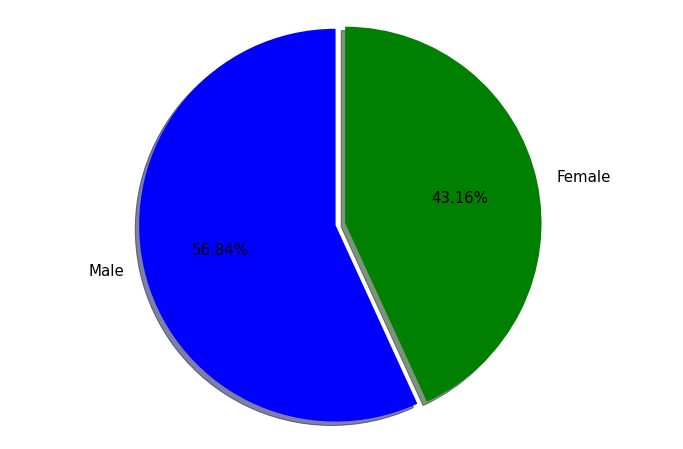

In [6]:
#ditribution of 'Male' , 'Female' from Finding label ( unique patient id) 
patients_with_findings = all_xray_df[all_xray_df['Finding Labels'].values != 'No Finding']
Male=(patients_with_findings['Patient Gender'].values == 'M').sum()
Female=(patients_with_findings['Patient Gender'].values == 'F').sum()
fig1, ax1 = plt.subplots(figsize = (12, 8))
plt.rcParams['font.size'] = 15
ax1.pie([Male, Female],explode=(0,0.05),labels=['Male', 'Female'], autopct='%1.2f%%',
        shadow=True, startangle=90,colors = ['blue', 'green'] )
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Text(0, 0.5, 'Count of Patients')

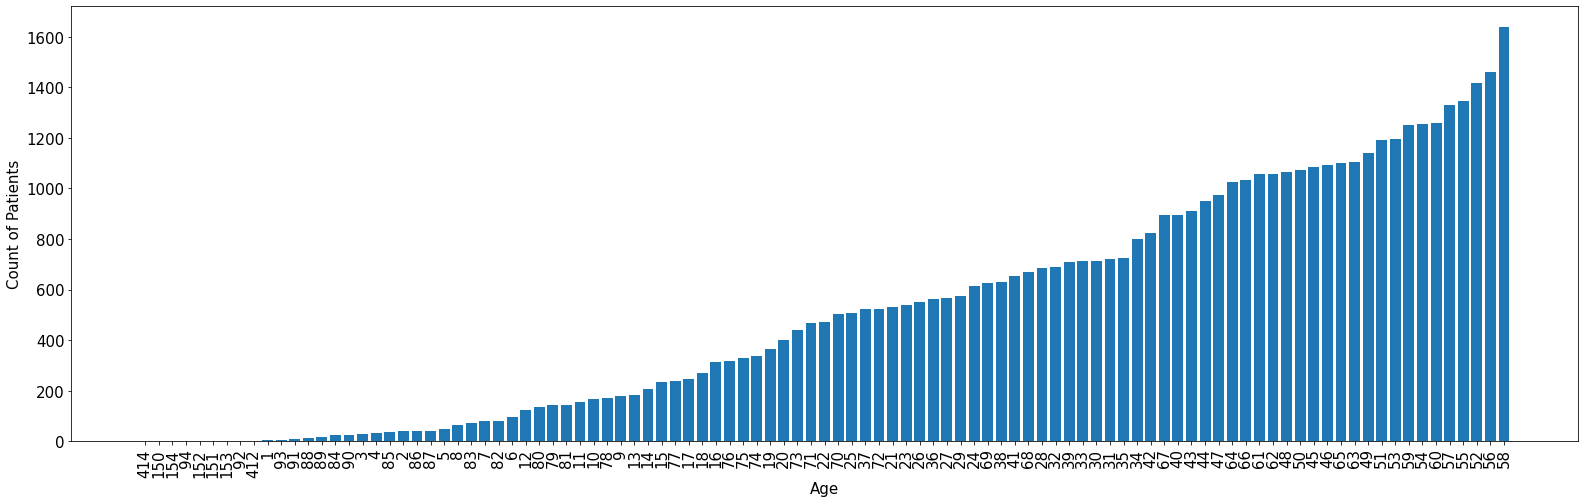

In [7]:
# age distribution 
label_counts = all_xray_df[all_xray_df['Finding Labels'].values != 'No Finding']['Patient Age'].value_counts().sort_values()
fig, ax1 = plt.subplots(1,1,figsize = (27, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

ax1.set_xlabel("Age")
ax1.set_ylabel("Count of Patients")

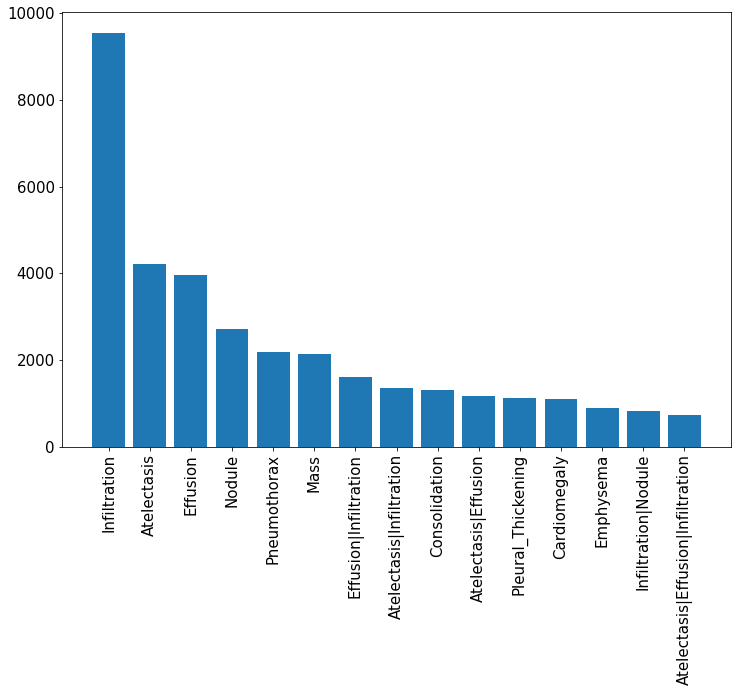

In [8]:
#Disease distribution 
label_counts = all_xray_df[all_xray_df['Finding Labels'].values != 'No Finding']['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)


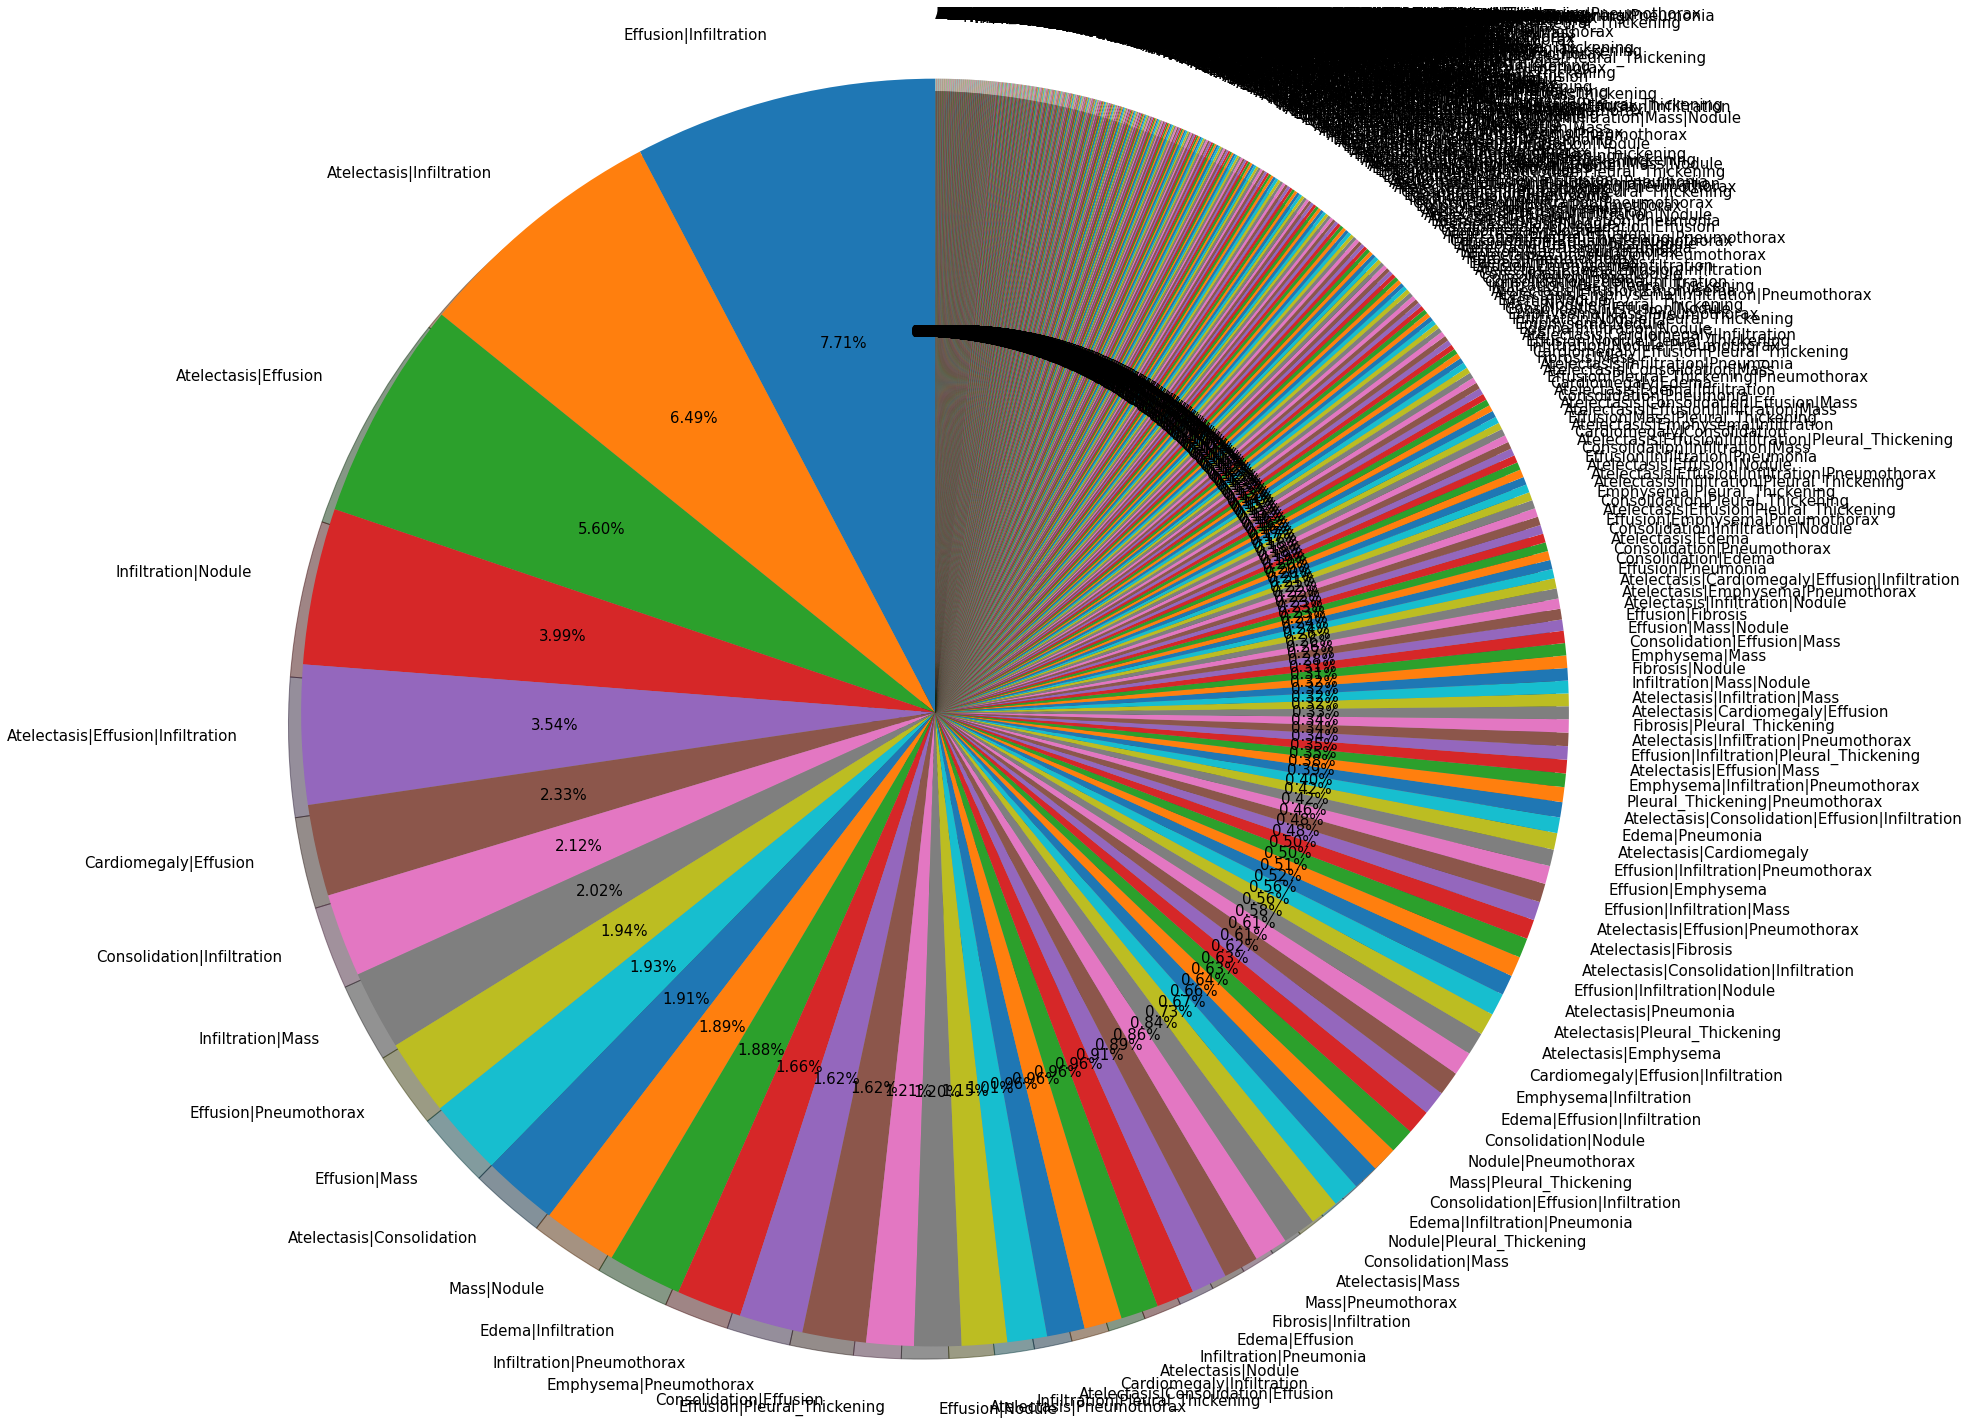

In [9]:

Finding_more_labels=patients_with_findings[patients_with_findings['Finding Labels'].str.contains(re.escape('|'))]
Findingttt = Finding_more_labels['Finding Labels'].value_counts().reset_index()
Findingttt.columns = ['col', 'count']



fig1, ax1 = plt.subplots(figsize = (25, 25))
plt.rcParams['font.size'] = 15
ax1.pie(Findingttt['count'],labels=Findingttt['col'].unique(), autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

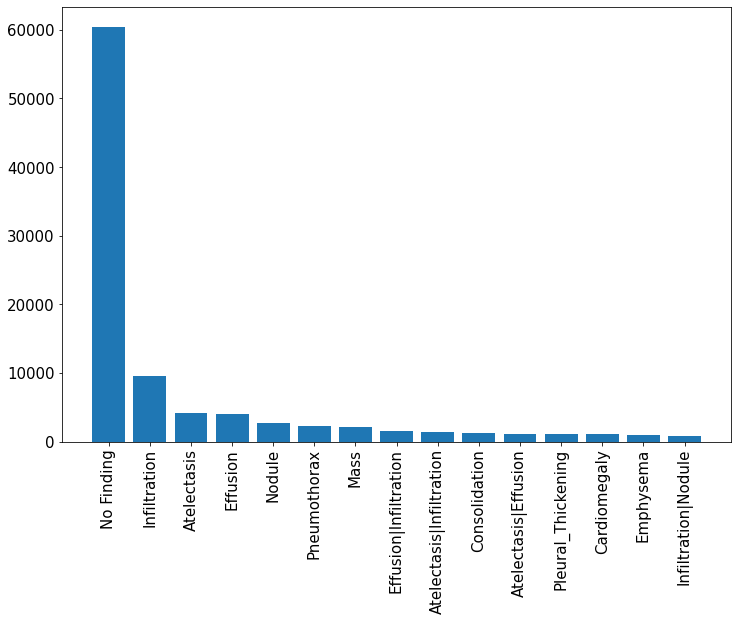

In [10]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [11]:
AXD=all_xray_df[all_xray_df['Finding Labels'].values != 'No Finding']

all_labels = np.unique(list(chain(*AXD['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
print(all_labels)
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        print(c_label)
        AXD[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
print(len(AXD))
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if AXD[c_label].sum()>MIN_CASES]
AXD['disease_vec'] = AXD.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
print(len(AXD))

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Atelectasis
Cardiomegaly
Consolidation


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Edema
Effusion
Emphysema
Fibrosis
Hernia
Infiltration
Mass
Nodule
Pleural_Thickening
Pneumonia
Pneumothorax
51759
51759


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
AXD=AXD[AXD['Patient Age'].values <=100]
print((AXD))

In [ ]:
#using the image genrator class to artifiically create image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [ ]:
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 1,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

In [ ]:
## sample attempt to see how image genrator class works for one image
def generate_plot_pics(datagen,orig_img): dir_augmented_data = "../output" try:

    ## if the preview folder does not exist, create
    os.mkdir(dir_augmented_data)
except:
    ## if the preview folder exists, then remove
    ## the contents (pictures) in the folder
    for item in os.listdir(dir_augmented_data):
        os.remove(dir_augmented_data + "/" + item)

## convert the original image to array
x = img_to_array(orig_img)
## reshape (Sampke, Nrow, Ncol, 3) 3 = R, G or B
x = x.reshape((1,) + x.shape)
## -------------------------- ##
## randomly generate pictures
## -------------------------- ##
i = 0
Nplot = 8
for batch in datagen.flow(x,batch_size=1,
                      save_to_dir=dir_augmented_data,
                      save_prefix="pic",
                      save_format='jpeg'):
    i += 1
    if i > Nplot - 1: ## generate 8 pictures 
        break

## -------------------------- ##
##   plot the generated data
## -------------------------- ##
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.02,wspace=0.01,
                left=0,right=1,bottom=0, top=1)

## original picture
ax = fig.add_subplot(3, 3, 1,xticks=[],yticks=[])        
ax.imshow(orig_img)
ax.set_title("original")

i = 2
for imgnm in os.listdir(dir_augmented_data):
    ax = fig.add_subplot(3, 3, i,xticks=[],yticks=[]) 
    img = load_img(dir_augmented_data + "/" + imgnm)
    ax.imshow(img)
    i += 1
plt.show()

In [ ]:
#applciation of image generator class. 
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):

    base_dir = os.path.dirname(in_df[path_col].values[0])
    print(base_dir)
    print(len(in_df[path_col].values[0]))
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    print(df_gen.class_indices)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    print(np.stack(in_df[y_col].values))
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0] 
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    print("ll")
    print(len(df_gen))
    return df_gen

In [ ]:
#applciation of image genrator to train and test
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) 
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))

In [ ]:

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')


In [ ]:
#Creating layers., Mobile Net

base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))

multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                               metrics = ['binary_accuracy', 'mae'])
# metrics = ['binary_accuracy', 'mae']
multi_disease_model.summary()


In [ ]:
#saving the weights
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]


In [ ]:
!pip install h5py

#data modelling
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)
    


In [ ]:
#predicting.
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

In [ ]:
#ROC curve polting
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')